In [ ]:
import importlib
 
if importlib.util.find_spec('fsspec') is None:
  !pip install fsspec
if importlib.util.find_spec('s3fs') is None:
  !pip install s3fs
  
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

     |████████████████████████████████| 102kB 4.1MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 1.3MB 8.5MB/s 
     |████████████████████████████████| 6.5MB 13.1MB/s 
     |████████████████████████████████| 296kB 48.4MB/s 
     |████████████████████████████████| 143kB 39.0MB/s 
     |████████████████████████████████| 552kB 45.4MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=84c550caff3fa2552adb70fed7c01954742bffe5395653f2b1d3c7470bb9d41a
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16


<h3> Read Data</h3><br>
The data to be retrieved is defined as a dictionary. We are keen to retrieve the data for Ford (F) and GE (F)

In [ ]:
df_GE = pd.read_excel('s3://lfspf/GE.xlsx')
df_F = pd.read_excel('s3://lfspf/FORD.xlsx')


Quick inspection of the data

In [ ]:
df_GE.set_index('date',inplace=True)
df_F.set_index('date',inplace=True)
df_F.head()

,F
date,
2010-10-01,12.26
2010-10-04,12.84
2010-10-05,13.01
2010-10-06,13.24
2010-10-07,13.32


Slice on a particular day

In [ ]:
df_F.loc['2018-09-25']

F    9.39
Name: 2018-09-25 00:00:00, dtype: float64

<h3> Create one datastructure </h3>
Consolidate the Data of Ford and GE into one single DataFrame

In [ ]:

df = pd.concat([df_F,df_GE],axis=1)
df.head()

,F,GE
date,,
2007-10-23,NaN,40.48
2007-10-24,NaN,40.23
2007-10-25,NaN,40.16
2007-10-26,NaN,40.38
2007-10-29,NaN,40.56


<b>Task:</b> Remove all the entries where there are missing values.

In [ ]:
df.dropna(how='any',inplace=True)

<b>Task:</b>What values do you have for Jan8th, 2018 ?

In [ ]:
df.loc['2018-01-08',:]

F     13.15
GE    18.28
Name: 2018-01-08 00:00:00, dtype: float64

Calculate the difference between the return of GE and F

In [ ]:
df_ret = df.pct_change(periods=1)
df_ret.head()

,F,GE
date,,
2010-10-01,NaN,NaN
2010-10-04,0.047308,-0.015892
2010-10-05,0.013240,0.025466
2010-10-06,0.017679,0.023622
2010-10-07,0.006042,0.008876


In [ ]:
df_ret['Diff']= df_ret['GE']-df_ret['F']

In [ ]:
def my_func(x):
    return np.abs(x)/2

In [ ]:
df_ret['Diff']=df_ret['Diff'].apply(lambda x : my_func(x))
df_ret.head()

,F,GE,Diff
date,,,
2010-10-01,NaN,NaN,NaN
2010-10-04,0.047308,-0.015892,0.031600
2010-10-05,0.013240,0.025466,0.006113
2010-10-06,0.017679,0.023622,0.002972
2010-10-07,0.006042,0.008876,0.001417


<h3>Graph</h3>
DataFrames have their own build-in functions

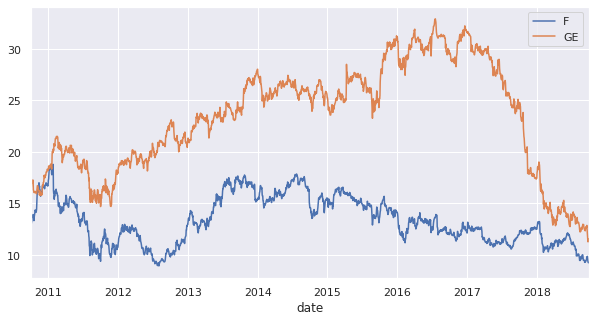

In [ ]:
df.plot(figsize=(10,5));

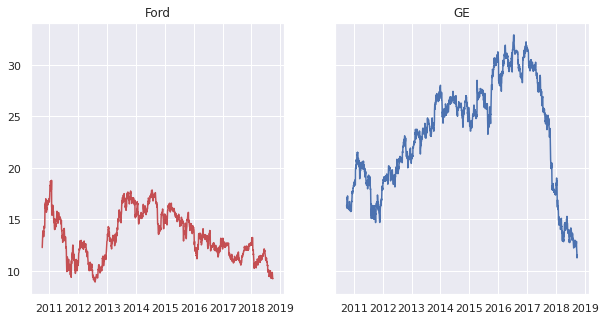

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].plot(df.index,df['F'],'r',label='F')
ax[1].plot(df.index,df['GE'],'b',label='GE')
ax[0].set_title('Ford')
ax[1].set_title('GE');

<h3>Rolling Windows</h3>

Rolling 30 D Volatility

In [ ]:
df_F['logret'] =df_F['F'].pct_change(periods=1).apply(lambda x : np.log(1+x))
df_GE['logret'] =df_GE['GE'].pct_change(periods=1).apply(lambda x : np.log(1+x))

In [ ]:
df_F.head()

,F,logret
date,,
2010-10-01,12.26,NaN
2010-10-04,12.84,0.046223
2010-10-05,13.01,0.013153
2010-10-06,13.24,0.017524
2010-10-07,13.32,0.006024


In [ ]:
df_F['30D Vol']= df_F['logret'].rolling(window=20).apply(lambda x : np.std(x)*np.sqrt(250),raw=False)
df_GE['30D Vol']= df_GE['logret'].rolling(window=20).apply(lambda x : np.std(x)*np.sqrt(250),raw=False)

Text(0, 0.5, 'Volatility %')

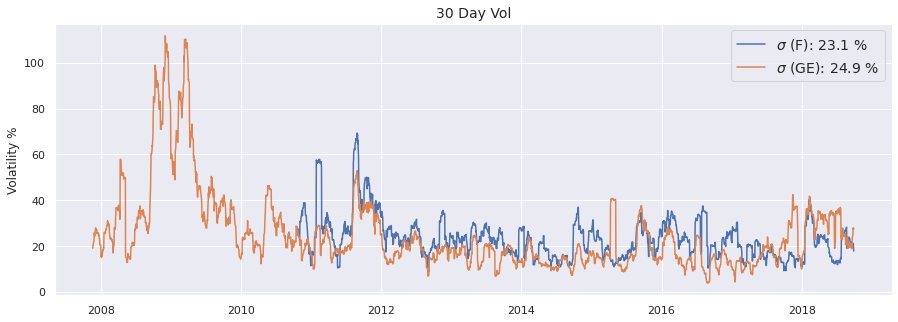

In [ ]:
fig , ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(df_F.index,df_F['30D Vol']*100,label='$\sigma$ (F): '+str(100*np.round(df_F['30D Vol'].mean(),3))+ ' %')
ax.plot(df_GE.index,df_GE['30D Vol']*100,label='$\sigma$ (GE): '+str(100*np.round(df_GE['30D Vol'].mean(),3))+' %')
ax.set_title('30 Day Vol',fontsize=14)
ax.legend(fontsize=14)
ax.set_ylabel('Volatility %')

<h3> Rolling Correlation </h3>

In [ ]:
df_ret = pd.concat([df_F['logret'],df_GE['logret']],axis=1)

In [ ]:
df_ret.columns = ['F','GE']
df_ret.head()

,F,GE
date,,
2007-10-23,NaN,NaN
2007-10-24,NaN,-0.006195
2007-10-25,NaN,-0.001742
2007-10-26,NaN,0.005463
2007-10-29,NaN,0.004448


In [ ]:
df_ret.dropna(how='any',inplace=True)

In [ ]:
df_ret['corr']= df_ret['F'].rolling(window=180).corr(df['GE'])

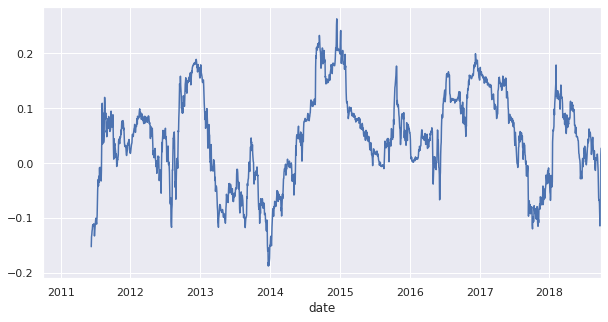

In [ ]:
df_ret['corr'].plot(figsize=(10,5))